SIN-393 - Introdução à Visão Computacional (2022-2)

# Aula 10 - Segmentação semântica

Prof. João Fernando Mari ([*joaofmari.github.io*](https://joaofmari.github.io/))

---

* Baseado no tutorial:
    * U-Net: Training Image Segmentation Models in PyTorch
        * https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* A implementação da U-Net foi baseada em:
    * U-Net: A PyTorch Implementation in 60 lines of Code
        * https://amaarora.github.io/2020/09/13/unet.html

## Importando as bibliotecas
---

In [1]:
import os
import glob

import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torch
import time
import os

from torch.nn import functional as F
from torch.utils.data import Dataset

from torchvision import transforms

##  Conjunto de dados
---

* TGS Salt Identification Challenge
    * https://www.kaggle.com/c/tgs-salt-identification-challenge

In [2]:
# Caminho para o conjunto de imagens
DS_PATH = '/home/joao/Datasets/TGS Salt Identification/competition_data/train/'

# Caminho da pasta com as imagens
IMAGE_PATH = os.path.join(DS_PATH, "images")
# Caminho para a pasta com as máscaras
MASK_PATH = os.path.join(DS_PATH, "masks")

## Configurando acesso à GPU
---

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

cuda


In [4]:
# Taxa de aprendizado
INIT_LR = 0.001
# Número total de épocas de treinamento
NUM_EPOCHS = 20 # 40
# Tamanho do mini-lote
BATCH_SIZE = 64

# Limiar para gerar imagem segmentada
THRESHOLD = 0.5

In [5]:
# Número de canais nas imagens de entrada
NUM_CHANNELS = 1
# Número de classes
NUM_CLASSES = 1

# Tamanho das imagens de entrada (largura, altura)
INPUT_WIDTH = 128
INPUT_HEIGHT = 128

## Dataset 
---

In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # Caminhos para as imagens
        self.imagePaths = imagePaths
        # Caminhos para as máscaras
        self.maskPaths = maskPaths
        # Transformações
        self.transforms = transforms
        
    def __len__(self):
        # Número de amostras no dataset
        return len(self.imagePaths)
    
    def __getitem__(self, idx):
        # Obtém o caminho para a imagem
        imagePath = self.imagePaths[idx]
        # Carrega a imagem
        image = cv2.imread(imagePath)
        # Converte de BGR para RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Carrega máscara de segmentação assiciada à imagem
        mask = cv2.imread(self.maskPaths[idx], 0)
        
        if self.transforms is not None:
            # Apllica as transformações, caso existam
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        # Retorna uma tupla com imagem e máscara
        return (image, mask)

## Definindo uma U-Net
---
* U-Net: A PyTorch Implementation in 60 lines of Code
    * https://amaarora.github.io/2020/09/13/unet.html

In [7]:
class Block(nn.Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        # store the convolution and RELU layers
        self.conv1 = nn.Conv2d(inChannels, outChannels, 3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(outChannels, outChannels, 3)
        
    def forward(self, x):
        # CONV => RELU => CONV
        return self.conv2(self.relu(self.conv1(x)))
    
    
class Encoder(nn.Module):
    
    def __init__(self, channels=(3, 16, 32, 64)):
        super().__init__()
        # store the encoder blocks and maxpooling layer
        self.encBlocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        # initialize an empty list to store the intermediate outputs
        blockOutputs = []
        
        # loop through the encoder blocks
        for block in self.encBlocks:
            # pass the inputs through the current encoder block, 
            x = block(x)
            # store the outputs
            blockOutputs.append(x)
            # apply maxpooling on the output
            x = self.pool(x)
        
        # return the list containing the intermediate outputs
        return blockOutputs

    
class Decoder(nn.Module):
    
    def __init__(self, channels=(64, 32, 16)):
        super().__init__()
        # Number of channels
        self.channels = channels
        # Upsampler blocks
        self.upconvs = nn.ModuleList(
            [nn.ConvTranspose2d(channels[i], channels[i + 1], 2, 2) for i in range(len(channels) - 1)]
        )
        # Decoder blocks
        self.dec_blocks = nn.ModuleList(
            [Block(channels[i], channels[i + 1]) for i in range(len(channels) - 1)]
        )
    
    def forward(self, x, encFeatures):
        # loop through the number of channels
        for i in range(len(self.channels) - 1):
            # pass the inputs through the upsampler blocks
            x = self.upconvs[i](x)
            # crop the current features from the encoder blocks,
            encFeat = self.crop(encFeatures[i], x)
            # concatenate them with the current upsampled features,
            x = torch.cat([x, encFeat], dim=1)
            # pass the concatenated output through the current decoder block
            x = self.dec_blocks[i](x)

        # return the final decoder output
        return x
    
    def crop(self, encFeatures, x):
        # Grab the dimensions of the inputs
        (_, _, H, W) = x.shape
        # Crop the encoder features to match the dimensions
        encFeatures = transforms.CenterCrop([H, W])(encFeatures)
        # Return the cropped features
        return encFeatures


class UNet(nn.Module):
    def __init__(self, encChannels=(3, 16, 32, 64),
                 decChannels=(64, 32, 16),
                 nbClasses=1, retainDim=True,
                 outSize=(INPUT_HEIGHT, INPUT_WIDTH)):
        
        super().__init__()
        # initialize the encoder and decoder
        self.encoder = Encoder(encChannels)
        self.decoder = Decoder(decChannels)
        
        # initialize the regression head and store the class variables
        self.head = nn.Conv2d(decChannels[-1], nbClasses, 1)
        
        self.retainDim = retainDim
        self.outSize = outSize
        
    def forward(self, x):
        # grab the features from the encoder
        encFeatures = self.encoder(x)
        
        # pass the encoder features through decoder making sure that
        # their dimensions are suited for concatenation
        decFeatures = self.decoder(encFeatures[::-1][0], 
                                   encFeatures[::-1][1:])
        
        # pass the decoder features through the regression head to obtain the segmentation mask
        map = self.head(decFeatures)
        
        # if we are retaining the original output dimensions
        #   then resize the output to match them
        if self.retainDim:
            map = F.interpolate(map, self.outSize)
            
        # Retorna o mapa de caracteristicas
        return map

## Dividindo o dataset em treino e teste
---

In [8]:
# Carrega os caminhos para as imagens e coloca em ordem alfabética
imagePaths = sorted(glob.glob(os.path.join(IMAGE_PATH, '*')))
# Carrega os caminhos para as máscaras e coloca em ordem alfabética
maskPaths = sorted(glob.glob(os.path.join(MASK_PATH, '*')))

# Divide o conjunto de dados. 15% para testes e 85% para treinamento.
trainImages, testImages, trainMasks, testMasks = train_test_split(imagePaths, 
                                                                  maskPaths, 
                                                                  test_size=0.15, 
                                                                  random_state=42)

## Defininfo datasets e dataloaders
---

In [9]:
# Defininfo as transformações
transforms_ = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Resize((INPUT_HEIGHT, INPUT_WIDTH)),
                                  transforms.ToTensor()])

# Criando os datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks, transforms=transforms_)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks, transforms=transforms_)
print(f"{len(trainDS)} images in the training set...")
print(f"{len(testDS)} images in the test set...")

# Criando os dataloaders
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                         num_workers=os.cpu_count())
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY,
                        num_workers=os.cpu_count())

3400 images in the training set...
600 images in the test set...


## Construindo o modelo
---

In [10]:
# Inicializa o modelo
unet = UNet()

# Envia o modelo para o DEVICE
unet = unet.to(DEVICE)

In [11]:
# Função de perda (loss) 
lossFunc = BCEWithLogitsLoss()

# Otimizador - SGD
opt = Adam(unet.parameters(), lr=INIT_LR)

In [12]:
# Usado para calcular as médias das perdas durante o treinamento
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE

## Treinando o modelo
---

In [13]:
print("training the network...")
startTime = time.time()

# Listas contendo as perdas em cada época para treino e teste.
train_loss_list = []
test_loss_list = []

for e in range(NUM_EPOCHS):
    # Modo de treinamento
    unet.train()
    
    # TRAINING
    # ========
    # Inicializa a perda do treinamento.
    totalTrainLoss = 0
    
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        # >>>> FORWARD
        pred = unet(x)
        
        # Calcula a perda (loss)
        loss = lossFunc(pred, y)
        
        # Zera os gradientes acumulados.
        opt.zero_grad()
        
        # <<<< BACKWARD
        loss.backward()
        
        # Otimiza os parametros do modelo
        opt.step()
        
        # Acumula a perda da época
        totalTrainLoss += loss
    
    # VALIDATION
    # ==========
    # Inicializa a perda da época
    totalTestLoss = 0
    
    # Desabilita o calculo do gradiente durante a validação
    with torch.no_grad():
        # Modo de avaliação
        unet.eval()
        
        # loop over the validation set
        for (x, y) in testLoader:
            # Envia as entradas para o DEVICE
            x = x.to(DEVICE) 
            y = y.to(DEVICE)
            
            # >>>> FORWARD 
            pred = unet(x)
            
            # Calcula a perda 
            loss = lossFunc(pred, y)
            
            # Acumula a perda da época
            totalTestLoss += loss
    
    # Calcula as médias das perdas
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    # Atualiza as listas que contém os históricos de treinamento.
    train_loss_list.append(avgTrainLoss.cpu().detach().numpy())
    test_loss_list.append(avgTestLoss.cpu().detach().numpy())

    # Printing...
    print("EPOCH: {}/{}, Train loss: {:.6f}, Test loss: {:.4f}".format(e + 1, NUM_EPOCHS, avgTrainLoss, avgTestLoss))

# Tempo total do treinamento
endTime = time.time()
print("Time to train the model: {:.2f}s".format(endTime - startTime))

training the network...
EPOCH: 1/20, Train loss: 0.578915, Test loss: 0.6141
EPOCH: 2/20, Train loss: 0.569432, Test loss: 0.6088
EPOCH: 3/20, Train loss: 0.563734, Test loss: 0.5825
EPOCH: 4/20, Train loss: 0.555380, Test loss: 0.5544
EPOCH: 5/20, Train loss: 0.492563, Test loss: 0.5608
EPOCH: 6/20, Train loss: 0.454778, Test loss: 0.4501
EPOCH: 7/20, Train loss: 0.417368, Test loss: 0.4696
EPOCH: 8/20, Train loss: 0.412752, Test loss: 0.4301
EPOCH: 9/20, Train loss: 0.400168, Test loss: 0.4187
EPOCH: 10/20, Train loss: 0.390088, Test loss: 0.4161
EPOCH: 11/20, Train loss: 0.393578, Test loss: 0.4136
EPOCH: 12/20, Train loss: 0.378040, Test loss: 0.3774
EPOCH: 13/20, Train loss: 0.363267, Test loss: 0.3787
EPOCH: 14/20, Train loss: 0.369040, Test loss: 0.3767
EPOCH: 15/20, Train loss: 0.364405, Test loss: 0.3779
EPOCH: 16/20, Train loss: 0.377186, Test loss: 0.3809
EPOCH: 17/20, Train loss: 0.359833, Test loss: 0.3686
EPOCH: 18/20, Train loss: 0.353130, Test loss: 0.3678
EPOCH: 19/20,

## Plota as curvas de treinamento
---

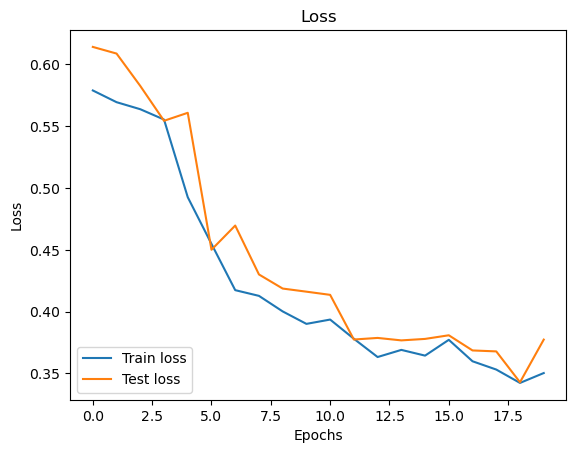

In [14]:
plt.figure()
plt.plot(train_loss_list, label="Train loss")
plt.plot(test_loss_list, label="Test loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="lower left")

## Plota os resultados da segmentação
---

In [15]:
def prepare_plot(origImage, origMask, predMask):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    # Imagem
    ax[0].imshow(origImage)
    ax[0].set_title("Image")
    # Máscara
    ax[1].imshow(origMask)
    ax[1].set_title("Original Mask")
    # Predição
    ax[2].imshow(predMask)
    ax[2].set_title("Predicted Mask")

    figure.tight_layout()
    figure.show()

In [16]:
### Algumas imagens. Para visualização.
imagePaths = np.random.choice(testImages, size=10)
# Todas as imagens. Para testes.
### imagePaths = testImages

# TESTE
### print(imagePaths)

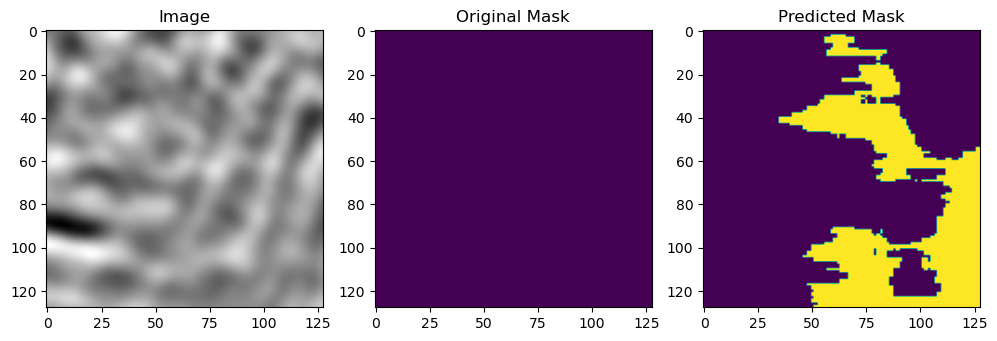

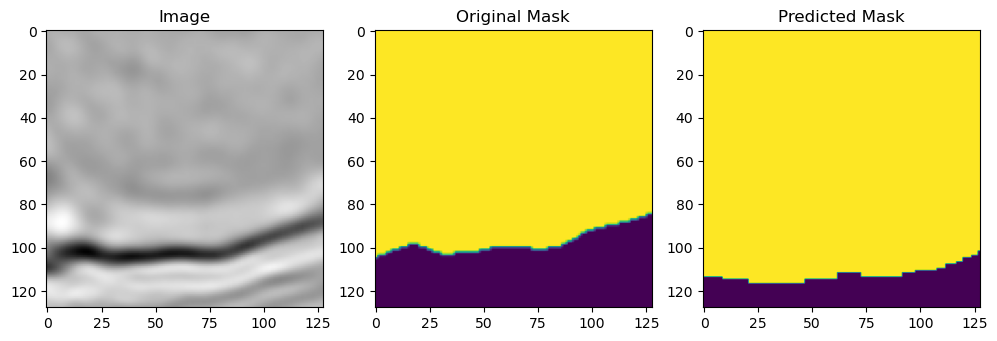

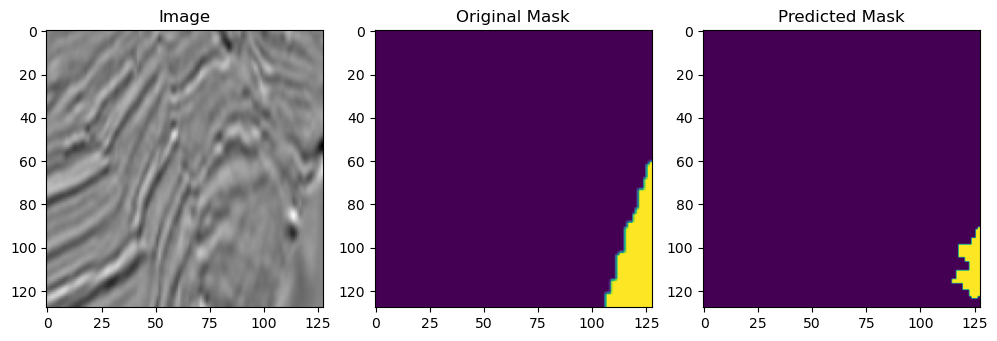

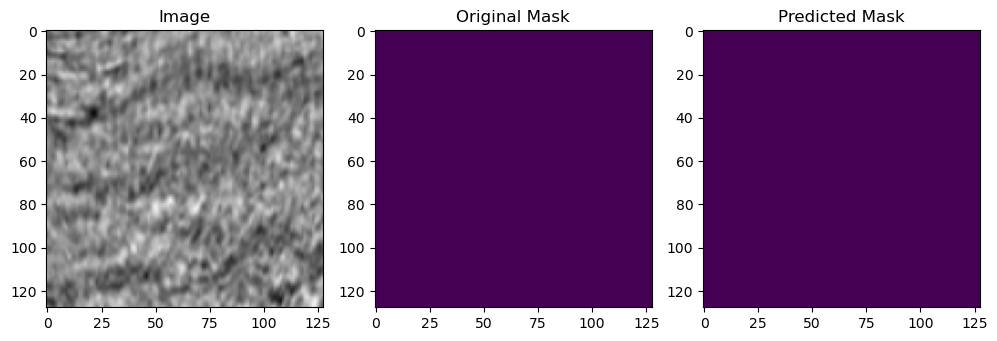

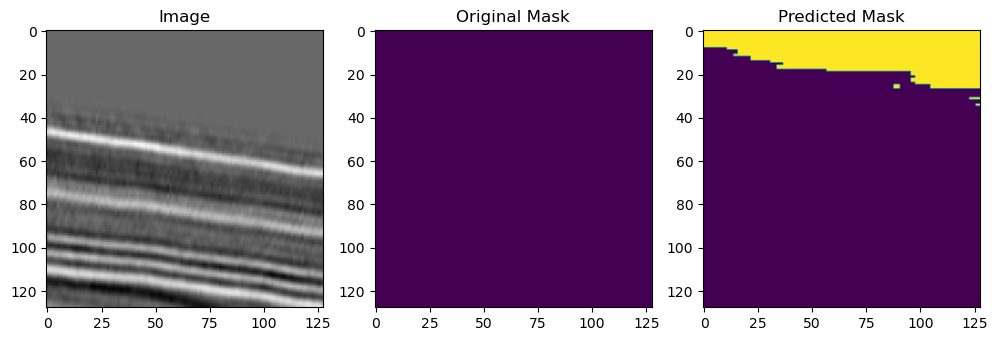

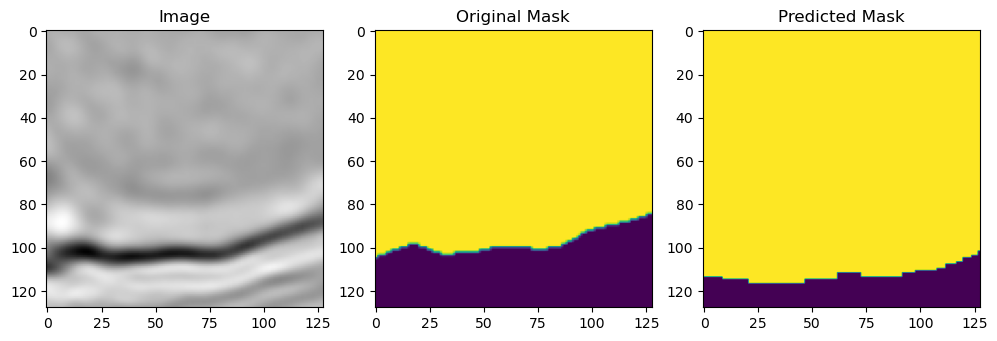

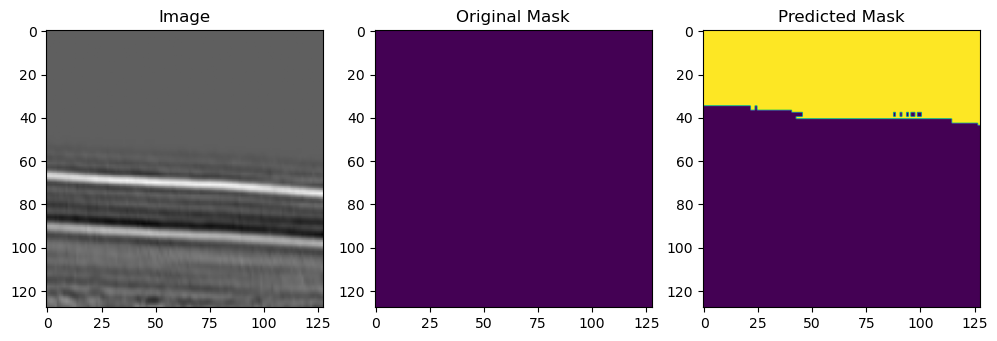

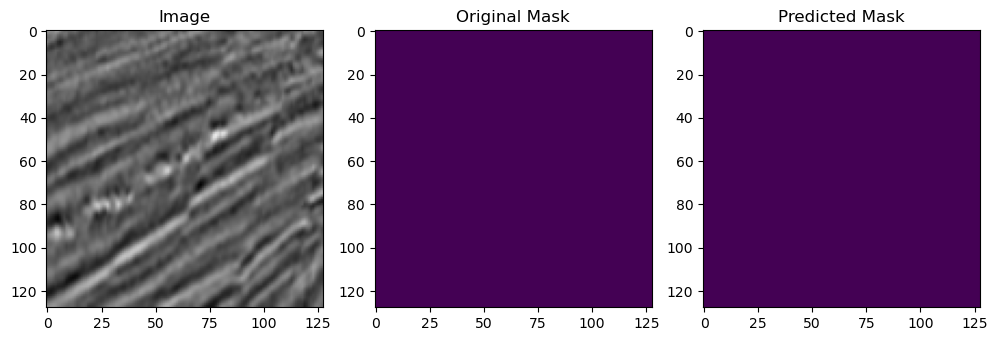

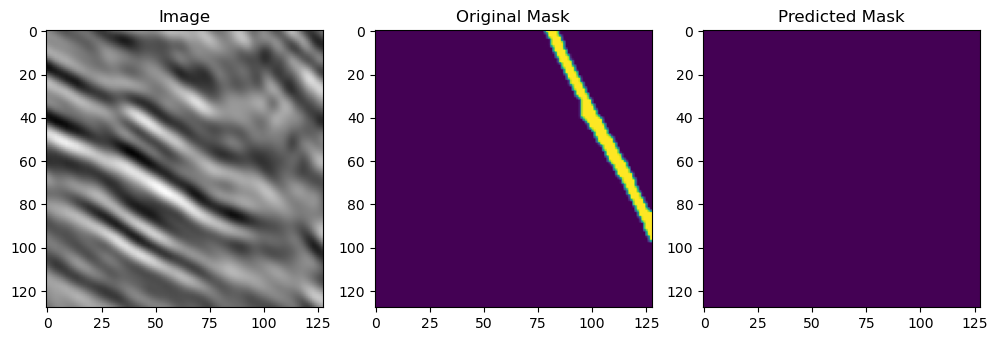

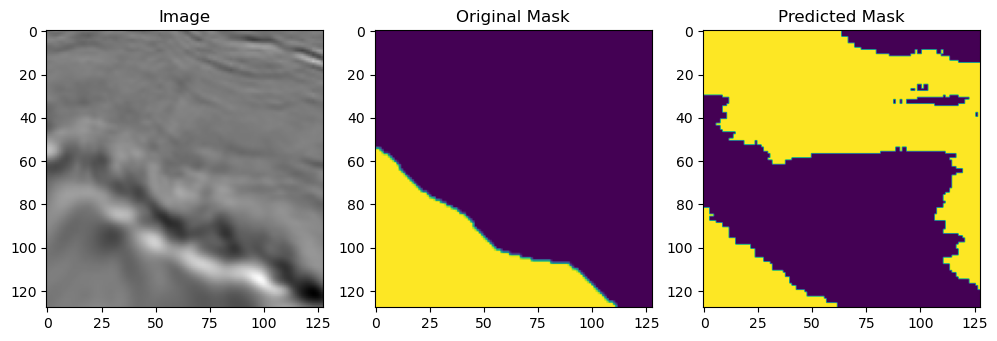

In [17]:
for imagePath in imagePaths:
    # Modo de avaliação
    unet.eval()
    # Desabilita o calculo do gradiente
    with torch.no_grad():
        # Carrega a imagem
        image = cv2.imread(imagePath)
        # Converte BGR (padrão do OpenCV) para RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Converte a imagem de inteiro para float [0..1]
        image = image.astype("float32") / 255.0
        
        # Redimensiona a imagem
        image = cv2.resize(image, (INPUT_HEIGHT, INPUT_HEIGHT))
        # Gera uma cópia da imagem para visualização
        orig = image.copy()
        
        # Gera o caminho para máscara baseado no caminho para a imagem.
        filename = imagePath.split(os.path.sep)[-1]
        groundTruthPath = os.path.join(MASK_PATH, filename)
        # Carrega a máscara de segmentação ground-truth. Para avaliar a segmentação.
        gtMask = cv2.imread(groundTruthPath, 0)
        # Redimensiona a máscara.
        gtMask = cv2.resize(gtMask, (INPUT_HEIGHT, INPUT_HEIGHT))
        
        # Converte HxWxC para CxHxW
        image = np.transpose(image, (2, 0, 1))
        # Adiciona uma dimensão. Gerando um lote com uma imagem.
        image = np.expand_dims(image, 0)
        # Cria um tensor PyTorch
        image = torch.from_numpy(image)
        # Envia o tensor para o DEVICE
        image = image.to(DEVICE)
        
        # >>>> FORWARD
        # Predição 
        predMask = unet(image).squeeze()
        # Passa a predição por uma função sigmóide (apenas para segmentação em duas classes)
        predMask = torch.sigmoid(predMask)
        # Envia para a CPU e converte para NumPy array.
        predMask = predMask.cpu().numpy()
        
        # Filtra predições fracas
        predMask = (predMask > THRESHOLD) * 255
        # Converte o resultado para inteiro
        predMask = predMask.astype(np.uint8)
        
        # Plota o resultado da segmentação
        prepare_plot(orig, gtMask, predMask)

## Avaliando os resultados
---

In [18]:
# TODO!

## Bibliografia
---
* U-Net: Training Image Segmentation Models in PyTorch
    * https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/
* U-Net: A PyTorch Implementation in 60 lines of Code
    * https://amaarora.github.io/2020/09/13/unet.html